In [1]:
from asm import propagate_spatial_asm, propagate_asm_spatiotemporal
import matplotlib.pyplot as plt
import jax.numpy as jnp

In [2]:
tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to mtch 10pt font in document
    "axes.labelsize": 9,
    "font.size": 9,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9
}

plt.style.use('seaborn-v0_8-white')
plt.rcParams.update(tex_fonts)

# Spatial Propagation

In [3]:
N = 2048                # Number of grid points per side
L = 1.0e-3              # Grid side length (2 mm)
wavelength = 800e-9     # Wavelength (800 nm)
w0 = 100e-6             # Initial beam waist (100 um)

z_R = (jnp.pi * w0**2) / wavelength
z_prop = 2.0 * z_R

x = jnp.linspace(-L/2, L/2, N)
y = jnp.linspace(-L/2, L/2, N)
X, Y = jnp.meshgrid(x, y, indexing='ij')

# --- Initial Field (Gaussian Beam at z=0) ---
E_in = jnp.exp(-(X**2 + Y**2) / w0**2)
E_in = E_in.astype(jnp.complex128) # Ensure complex type
I_in = jnp.abs(E_in)**2

E_out = propagate_spatial_asm(E_in, z_prop, L, wavelength)
I_out = jnp.abs(E_out)**2

slice_in = I_in[N//2, :]
slice_out = I_out[N//2, :]
x_mm = x * 1e3 # x-axis in mm

/home/juardilag/miniconda3/envs/work/lib/python3.14/site-packages/jax/_src/numpy/array_methods.py:125: UserWarning: Explicitly requested dtype complex128 requested in astype is not available, and will be truncated to dtype complex64. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)


/tmp/ipykernel_9703/2891406077.py:13: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


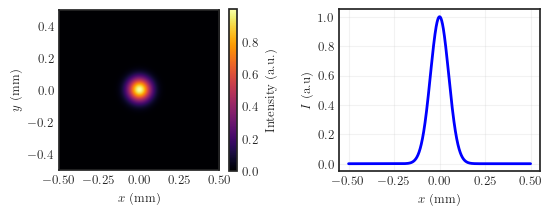

In [4]:
fig, ax = plt.subplots(1,2,figsize=(6.2, 2.1), gridspec_kw={'wspace': 0.4})

im = ax[0].imshow(I_in, extent=[x_mm[0], x_mm[-1], x_mm[0], x_mm[-1]], cmap='inferno', interpolation='bilinear')
ax[0].set_xlabel(r'$x$ (mm)')
ax[0].set_ylabel(r'$y$ (mm)')
plt.colorbar(im, label='Intensity (a.u.)')

ax[1].plot(x_mm, slice_in / jnp.max(slice_in), label='Input', color='blue', linewidth=2)
ax[1].grid(alpha = 0.25)
ax[1].set_xlabel(r'$x$ (mm)')
ax[1].set_ylabel(r'$I$ (a.u)')

plt.tight_layout()
plt.savefig('initial_space_profile.png', dpi = 300, bbox_inches ='tight')
plt.show()

/tmp/ipykernel_9703/2396085306.py:13: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


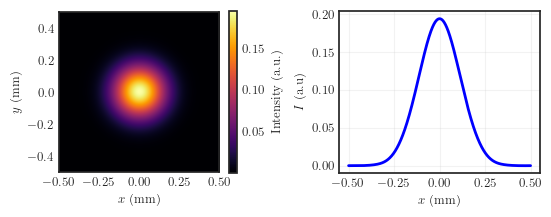

In [5]:
fig, ax = plt.subplots(1,2,figsize=(6.2, 2.1), gridspec_kw={'wspace': 0.4})

im = ax[0].imshow(I_out, extent=[x_mm[0], x_mm[-1], x_mm[0], x_mm[-1]], cmap='inferno', interpolation='bilinear')
ax[0].set_xlabel(r'$x$ (mm)')
ax[0].set_ylabel(r'$y$ (mm)')
plt.colorbar(im, label='Intensity (a.u.)')

ax[1].plot(x_mm, slice_out / jnp.max(slice_in), label='Input', color='blue', linewidth=2)
ax[1].grid(alpha = 0.25)
ax[1].set_xlabel(r'$x$ (mm)')
ax[1].set_ylabel(r'$I$ (a.u)')
    
plt.tight_layout()
plt.savefig('final_space_profile.png', dpi = 300, bbox_inches ='tight')
plt.show()

# Spatio-Temporal Propagation

In [6]:
# --- Simulation Parameters ---

# Spatial
N_x = 256              # Number of spatial grid points
L = 1.0e-3              # Grid side length (2 mm)
w0 = 100e-6             # Initial beam waist (100 um)

# Temporal
N_t = 256               # Number of temporal grid points (can be smaller now)
T = 5.0e-12            # Total time window (10 ps)
tau_0 = 1.0e-12         # Pulse duration (1 ps)

# Wavelength / Frequency
wavelength_0 = 800e-9   # Central wavelength (800 nm)

# Propagation
z_R = (jnp.pi * w0**2) / wavelength_0
z_prop = 2.0 * z_R  # Propagate by 1 Rayleigh range
# --- Grid Setup ---
# Spatial
x = jnp.linspace(-L/2, L/2, N_x)
X, Y = jnp.meshgrid(x, x, indexing='ij') # (N_x, N_x)

# Temporal
dt = T / N_t
t = jnp.linspace(-T/2, T/2, N_t) # (N_t,)

# --- Create 3D (t, x, y) Grids ---
T_grid = t[:, None, None]     # Shape (N_t, 1, 1)
X_grid = X[None, :, :]        # Shape (1, N_x, N_x)
Y_grid = Y[None, :, :]        # Shape (1, N_x, N_x)

# --- Initial Field E(t, x, y) ---
# E = E_spatial * E_temporal_envelope
E_spatial = jnp.exp(-(X_grid**2 + Y_grid**2) / w0**2)

# --- KEY CHANGE ---
# We do *NOT* include the carrier exp(-i*omega_0*t)
E_temporal_env = jnp.exp(-T_grid**2 / (2 * tau_0**2))

E_in_txy = E_spatial * E_temporal_env
E_in_txy = E_in_txy.astype(jnp.complex128) # Ensure complex

t_vec = t

# We pass the central wavelength to the propagator now
E_out_txy = propagate_asm_spatiotemporal(
    E_in_txy, z_prop, L, T, wavelength_0, n_func=None
)

/home/juardilag/miniconda3/envs/work/lib/python3.14/site-packages/jax/_src/numpy/array_methods.py:125: UserWarning: Explicitly requested dtype complex128 requested in astype is not available, and will be truncated to dtype complex64. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)


In [7]:
# Get intensities
I_in_txy = jnp.abs(E_in_txy)**2
I_out_txy = jnp.abs(E_out_txy)**2

vmax = I_out_txy.max()

x_mm = x * 1e3 # x-axis in mm

/tmp/ipykernel_9703/577074460.py:35: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


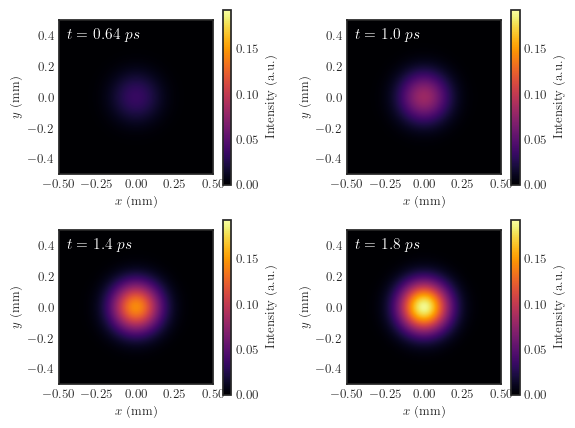

In [8]:
fig, ax = plt.subplots(2,2,figsize=(6.2, 5), gridspec_kw={'hspace': 0.2, 'wspace': 0.5})

im_1 = ax[0,0].imshow(I_out_txy[160,:,:], extent=[x_mm[0], x_mm[-1], x_mm[0], x_mm[-1]], cmap='inferno', interpolation='bilinear',
                    vmin = 0, vmax = vmax)
ax[0,0].set_xlabel(r'$x$ (mm)')
ax[0,0].set_ylabel(r'$y$ (mm)')
ax[0,0].text(0.05, 0.95, r'$t={:.2} \ ps$'.format(t[160]*1e12), transform=ax[0,0].transAxes, 
             fontsize=11, color='white', va='top')
plt.colorbar(im_1, label='Intensity (a.u.)')

im_2 = ax[0,1].imshow(I_out_txy[180,:,:], extent=[x_mm[0], x_mm[-1], x_mm[0], x_mm[-1]], cmap='inferno', interpolation='bilinear',
                    vmin = 0, vmax = vmax)
ax[0,1].set_xlabel(r'$x$ (mm)')
ax[0,1].set_ylabel(r'$y$ (mm)')
ax[0,1].text(0.05, 0.95, r'$t={:.2} \ ps$'.format(t[180]*1e12), transform=ax[0,1].transAxes, 
             fontsize=11, color='white', va='top')
plt.colorbar(im_2, label='Intensity (a.u.)')

im_3 = ax[1,0].imshow(I_out_txy[200,:,:], extent=[x_mm[0], x_mm[-1], x_mm[0], x_mm[-1]], cmap='inferno', interpolation='bilinear',
                    vmin = 0, vmax = vmax)
ax[1,0].set_xlabel(r'$x$ (mm)')
ax[1,0].set_ylabel(r'$y$ (mm)')
ax[1,0].text(0.05, 0.95, r'$t={:.2} \ ps$'.format(t[200]*1e12), transform=ax[1,0].transAxes, 
             fontsize=11, color='white', va='top')
plt.colorbar(im_3, label='Intensity (a.u.)')

im_4 = ax[1,1].imshow(I_out_txy[220,:,:], extent=[x_mm[0], x_mm[-1], x_mm[0], x_mm[-1]], cmap='inferno', interpolation='bilinear',
                    vmin = 0, vmax = vmax)
ax[1,1].set_xlabel(r'$x$ (mm)')
ax[1,1].set_ylabel(r'$y$ (mm)')
ax[1,1].text(0.05, 0.95, r'$t={:.2} \ ps$'.format(t[220]*1e12), transform=ax[1,1].transAxes, 
             fontsize=11, color='white', va='top')
plt.colorbar(im_4, label='Intensity (a.u.)')
    
plt.tight_layout()
plt.savefig('spatio_temporal_propagation.png', dpi = 300, bbox_inches ='tight')
plt.show()